# Importing libraries

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import joblib
import requests_cache
from sklearn.preprocessing import RobustScaler
from metpy.calc import wind_components
from metpy.units import units
from openmeteo_requests import Client
from retry_requests import retry
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import joblib
from math import radians, sin, cos, sqrt, atan2
import openmeteo_requests

# Loading Data

In [64]:
aqaba = pd.read_csv('Datasets-Ready/aqaba_Ready.csv')
ghor = pd.read_csv('Datasets-Ready/ghor_Ready.csv')
irbid = pd.read_csv('Datasets-Ready/irbid_Ready.csv')
irwaished = pd.read_csv('Datasets-Ready/irwaished_Ready.csv')
maan = pd.read_csv('Datasets-Ready/maan_Ready.csv')
mafraq = pd.read_csv('Datasets-Ready/mafraq_Ready.csv')
amman = pd.read_csv('Datasets-Ready/amman_Ready.csv')  
safawi = pd.read_csv('Datasets-Ready/safawi_Ready.csv')

In [65]:
names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
datasets = [aqaba, ghor, irbid, irwaished, maan, mafraq, amman, safawi]
coordinates = [            # (latitude, longitude)
    (29.5500, 35.0000),    # Aqabah
    (31.0333, 35.4667),    # Ghor
    (32.5500, 35.8500),    # Irbid
    (32.5000, 38.2000),    # Irwaished
    (30.1667, 35.7833),    # Maan
    (32.3667, 36.2500),    # Mafraq
    (31.7167, 35.9833),    # Amman
    (32.1608, 37.1539),    # Safawi
]
Stations = {}
for i in range(len(names)):
    Stations[names[i]] = {}
    Stations[names[i]]['coordinates'] = coordinates[i]
    Stations[names[i]]['dataset'] = datasets[i]
    

# Training Cloud Cover Models

In [4]:
def df_to_X_y(X_df, y_df, window_size=48, future=24):
    X, y = [], []
    for i in range(len(X_df) - window_size - future + 1):
        X.append(X_df.iloc[i:i+window_size].values)
        y.append(y_df.iloc[i+window_size:i+window_size+future].values.flatten())
    return np.array(X), np.array(y)

In [5]:
for i in range(len(names)):
    ############## Data Manipulation ##############
    df = datasets[i].copy()
    df.drop(['Liquid Precipitation'], axis=1, inplace=True)
    df['time'] = pd.to_datetime(df['Unnamed: 0'])
    df.drop(columns=['Unnamed: 0'], inplace=True)

    df['hour'] = df['time'].dt.hour
    df['month'] = df['time'].dt.month

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    input_features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                      'Atmospheric Pressure', 'Wind_U', 'Wind_V']
    target_feature = 'Cloud Cover %'

  
    split_index = int(len(df) * 0.95)
    train_df = df.iloc[:split_index].copy()
    val_df = df.iloc[split_index:].copy()

    # Scalers
    input_scaler = RobustScaler()
    input_scaler.fit(train_df[input_features])
    train_df[input_features] = input_scaler.transform(train_df[input_features])
    val_df[input_features] = input_scaler.transform(val_df[input_features])

    target_scaler = RobustScaler()
    target_scaler.fit(train_df[[target_feature]])
    train_df[target_feature] = target_scaler.transform(train_df[[target_feature]])
    val_df[target_feature] = target_scaler.transform(val_df[[target_feature]])

    # Save scalers
    input_scaler_path = f"Models/Cloud_Cover_Models/{names[i]}_input_scaler.save"
    target_scaler_path = f"Models/Cloud_Cover_Models/{names[i]}_target_scaler.save"
    joblib.dump(input_scaler, input_scaler_path)
    joblib.dump(target_scaler, target_scaler_path)

    # Apply window 
    X_train, y_train = df_to_X_y(train_df[input_features], train_df[[target_feature]])
    X_val, y_val = df_to_X_y(val_df[input_features], val_df[[target_feature]])

    ############## Model Definition and Training ##############
    model = Sequential([
        InputLayer(shape=(48, 6)),
        LSTM(64, return_sequences=True),
        LSTM(128),
        Dense(64, activation='relu'),
        Dense(24)  
    ])
    model.compile(optimizer=Adam(0.0001), loss=MeanSquaredError(), metrics=['mse'])

    model_path = f"Models/Cloud_Cover_Models/{names[i]}_cloud_model.keras"
    cp = ModelCheckpoint(model_path, save_best_only=True)

    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=10,
              batch_size=128,
              callbacks=[cp])

Epoch 1/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 381s 241ms/step - loss: 1.3978 - mse: 1.3978 - val_loss: 0.8295 - val_mse: 0.8295
Epoch 2/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 389s 245ms/step - loss: 1.1640 - mse: 1.1640 - val_loss: 0.8110 - val_mse: 0.8110
Epoch 3/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 389s 249ms/step - loss: 1.1305 - mse: 1.1305 - val_loss: 0.8253 - val_mse: 0.8253
Epoch 4/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 460s 260ms/step - loss: 1.0986 - mse: 1.0986 - val_loss: 0.8195 - val_mse: 0.8195
Epoch 5/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 451s 266ms/step - loss: 1.0610 - mse: 1.0610 - val_loss: 0.8057 - val_mse: 0.8057
Epoch 6/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 443s 267ms/step - loss: 1.0156 - mse: 1.0156 - val_loss: 0.8378 - val_mse: 0.8378
Epoch 7/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 443s 268ms/step - loss: 0.9842 - mse: 0.9842 - val_loss: 0.8412 - val_mse: 0.8412
Epoch 8/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 421s 269ms/step - loss: 0.9446 - mse: 0.9446 - val_loss: 0.8653 - val_mse: 0.8653
Epoch 9/

# Precipitation Models

In [59]:
class rain_dataset(Dataset):
    def __init__(self, df, seq_len=48, output_len=12):
        self.seq_len = seq_len
        self.output_len = output_len
        self.features = df[features].values.astype(np.float32)
        self.timestamps = df['time'].reset_index(drop=True)
        self.precip = df['Liquid Precipitation'].reset_index(drop=True).values
        self.X, self.y = [], []

        #sliding window
        for i in range(len(df) - seq_len - output_len):
            x_window = self.features[i:i+seq_len]
            y_hat = self.precip[i+seq_len:i+seq_len+output_len]

            start_time = self.timestamps[i]
            end_time = self.timestamps[i + seq_len + output_len - 1]
            expected_hours = seq_len + output_len - 1
            if (end_time - start_time).total_seconds() / 3600 != expected_hours:
                continue  

            y = float(np.sum(y_hat) > 0) 
            self.X.append(x_window)
            self.y.append(y)

        self.X = np.array(self.X, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [60]:
class RainLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(RainLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x) 
        return self.fc(hn[-1])  

In [61]:
features = [
    'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
    'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
]

In [66]:
for i in range(len(names)):
    ############## Data Manupilation ##############

    df = datasets[i].copy()
    df['time'] = pd.to_datetime(df['Unnamed: 0'])
    df.drop(columns=['Unnamed: 0'], inplace=True)

    df['hour'] = df['time'].dt.hour
    df['day_yr'] = df['time'].dt.dayofyear
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_yr'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_yr'] / 365)

    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    
    scaler_path = f"Models/Precipitation_Models/{names[i]}_scaler.pkl"
    joblib.dump(scaler, scaler_path)

    df['date'] = df['time'].dt.date
    rain_per_day = df.groupby('date')['Liquid Precipitation'].sum()
    rain_tomorrow = (rain_per_day.shift(-1) > 0).astype(int)
    df['RainTomorrow'] = df['date'].map(rain_tomorrow)

    df = df.dropna(subset=['RainTomorrow'])

    full = rain_dataset(df)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Splitting 
    train_len = int(len(full) * 0.95)
    train_ds = torch.utils.data.Subset(full, range(train_len))
    val_ds = torch.utils.data.Subset(full, range(train_len, len(full)))

    model = RainLSTM(input_size=len(features)).to(device)


    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=128, pin_memory=True)


    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    #Training loop
    for epoch in range(10):
        
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True).unsqueeze(1)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

    model_path  = f"Models/Precipitation_Models/{names[i]}_precipitation_model.pth"
    print(f"-----------------------\nTrained and saved model for: {names[i]}\n-----------------------")
    torch.save(model.state_dict(), model_path)

Epoch 1 - Loss: 0.0632
Epoch 2 - Loss: 0.0452
Epoch 3 - Loss: 0.0396
Epoch 4 - Loss: 0.0323
Epoch 5 - Loss: 0.0274
Epoch 6 - Loss: 0.0213
Epoch 7 - Loss: 0.0185
Epoch 8 - Loss: 0.0138
Epoch 9 - Loss: 0.0119
Epoch 10 - Loss: 0.0116
-----------------------
Trained and saved model for: aqaba
-----------------------
Epoch 1 - Loss: 0.1270
Epoch 2 - Loss: 0.1083
Epoch 3 - Loss: 0.0947
Epoch 4 - Loss: 0.0848
Epoch 5 - Loss: 0.0733
Epoch 6 - Loss: 0.0622
Epoch 7 - Loss: 0.0533
Epoch 8 - Loss: 0.0441
Epoch 9 - Loss: 0.0386
Epoch 10 - Loss: 0.0326
-----------------------
Trained and saved model for: ghor
-----------------------
Epoch 1 - Loss: 0.1866
Epoch 2 - Loss: 0.1618
Epoch 3 - Loss: 0.1433
Epoch 4 - Loss: 0.1279
Epoch 5 - Loss: 0.1116
Epoch 6 - Loss: 0.0964
Epoch 7 - Loss: 0.0826
Epoch 8 - Loss: 0.0684
Epoch 9 - Loss: 0.0610
Epoch 10 - Loss: 0.0520
-----------------------
Trained and saved model for: irbid
-----------------------
Epoch 1 - Loss: 0.1190
Epoch 2 - Loss: 0.1010
Epoch 3 - Los

# Generating output

In [27]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

In [26]:
def get_nearest_station(location):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
 
    coordinates = [            # (latitude, longitude)
    (29.5500, 35.0000),    # Aqabah
    (31.0333, 35.4667),    # Ghor
    (32.5500, 35.8500),    # Irbid
    (32.5000, 38.2000),    # Irwaished
    (30.1667, 35.7833),    # Maan
    (32.3667, 36.2500),    # Mafraq
    (31.7167, 35.9833),    # Amman
    (32.1608, 37.1539),    # Safawi
    ]
    lat, lon = location
    distances = []
    for stat_lat, stat_lon in coordinates:
        distances.append(haversine(lat, lon, stat_lat, stat_lon))
    closest_idx = int(np.argmin(distances))
    return names[closest_idx]
    

In [23]:

"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns closest station name and a single rain probability for next 24 hours
"""
def predict_rain_probability(location, df_48h, models_dir="Models/Precipitation_Models"):
    
    input_features = [
    'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
    'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
    ]
    
    #Find closest station
    station = get_nearest_station(location)

    #Load model and scaler
    scaler = joblib.load(f"{models_dir}/{station}_scaler.pkl")
    model = RainLSTM(input_size=11)
    model.load_state_dict(torch.load(f"{models_dir}/{station}_precipitation_model.pth", map_location=torch.device('cpu')))
    model.eval()

    #preprocessing 
    df = df_48h.copy()
    df['hour'] = df['time'].dt.hour
    df['day_yr'] = df['time'].dt.dayofyear
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_yr'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_yr'] / 365)

    df[input_features] = scaler.transform(df[input_features])
    input_data = df[input_features].values.astype(np.float32)

    #Padding just in case
    if len(input_data) < 48:
        pad_len = 48 - len(input_data)
        padding = np.repeat(input_data[-1:], pad_len, axis=0)
        input_data = np.vstack([input_data, padding])

    input_tensor = torch.tensor(input_data).unsqueeze(0)  #shape (1, 48, 11)

    with torch.no_grad():
        prob = model(input_tensor).item()

    return {
        "closest_station": station,
        "precipitation_probability": round(prob, 4)
    }

In [24]:
"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns cloud cover for next 24 hour time stamps
"""

def predict_cloud_cover(location, df_48h):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
    coordinates = [
        (29.5500, 35.0000), (31.0333, 35.4667), (32.5500, 35.8500), (32.5000, 38.2000),
        (30.1667, 35.7833), (32.3667, 36.2500), (31.7167, 35.9833), (32.1608, 37.1539),
    ]
    
    station = get_nearest_station(location)
    input_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_input_scaler.save")
    target_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_target_scaler.save")
    model = load_model(f"Models/Cloud_Cover_Models/{station}_cloud_model.keras")

    #Preprocess input dataframe
    df = df_48h.copy()
   

    df['hour'] = df['time'].dt.hour
    df['month'] = df['time'].dt.month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    input_features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                      'Atmospheric Pressure', 'Wind_U', 'Wind_V']
    X_input = input_scaler.transform(df[input_features])
    X_input = np.expand_dims(X_input, axis=0)  # Shape: (1, 48, 6)

    y_pred_scaled = model.predict(X_input)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    
    return y_pred.flatten()  # Shape: (24,)

# Testing on Amman data winter 2024

In [57]:
#load data
test_data = pd.read_csv("Amman_test_data/amman_test.csv")
test_data.tail()

,Unnamed: 0,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Liquid Precipitation,Cloud Cover %,Wind_U,Wind_V
3640,2024-05-30 17:00:00,11.0,21.0,52.8026,1012.3,0.0,0.0,7.24,-2.63
3641,2024-05-30 18:00:00,9.6,19.4,53.0921,1014.1,0.0,25.0,4.94,-2.85
3642,2024-05-30 19:00:00,11.0,17.0,67.7694,1014.1,0.0,0.0,2.10,0.00
3643,2024-05-30 20:00:00,12.0,17.0,72.4014,1014.1,0.0,0.0,3.12,-1.80
3644,2024-05-30 21:00:00,11.1,15.4,75.5450,1015.0,0.0,25.0,2.07,-0.36


In [58]:
test = test_data.copy()

In [59]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3645 entries, 0 to 3644
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            3645 non-null   object 
 1   Air Dew Point         3645 non-null   float64
 2   Air Temperature (OC)  3645 non-null   float64
 3   Humidity %            3645 non-null   float64
 4   Atmospheric Pressure  3645 non-null   float64
 5   Liquid Precipitation  3645 non-null   float64
 6   Cloud Cover %         3645 non-null   float64
 7   Wind_U                3645 non-null   float64
 8   Wind_V                3645 non-null   float64
dtypes: float64(8), object(1)
memory usage: 256.4+ KB


In [60]:
 test['Cloud Cover %'] = test['Cloud Cover %'].rolling(window=15, center=True).mean().fillna(method='bfill').fillna(method='ffill')

C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3151234567.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test['Cloud Cover %'] = test['Cloud Cover %'].rolling(window=15, center=True).mean().fillna(method='bfill').fillna(method='ffill')


In [61]:
test['time'] = pd.to_datetime(test['Unnamed: 0'])
test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [62]:
start_date = pd.to_datetime("2024-01-01")
end_date = pd.to_datetime("2024-03-30")

# Make sure test is sorted
test = test.sort_values("time").reset_index(drop=True)

predicted = []
actual = []
timestamps = []

# Step size of 24 instead of 1
step = 24
location = (31.95, 35.93)  # example: Amman

for i in tqdm(range(0, len(test) - 48 - 24 + 1, step)):
    df_48h = test.iloc[i:i+48]
    
    # Time range of prediction
    start_pred_time = df_48h['time'].iloc[-1] + pd.Timedelta(hours=1)
    time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')

    # Skip predictions outside desired range
    if time_range[-1] < start_date or time_range[0] > end_date:
        continue

    preds = predict_cloud_cover(location, df_48h)

    for t, p in zip(time_range, preds):
        if start_date <= t <= end_date:
            predicted.append(p)
            timestamps.append(t)
            actual_value = test.loc[test['time'] == t, 'Cloud Cover %']
            actual.append(actual_value.values[0] if not actual_value.empty else np.nan)

# Assemble results
results_df = pd.DataFrame({
    "time": timestamps,
    "predicted": predicted,
    "actual": actual
}).dropna()



  0%|                                                                                          | 0/149 [00:00<?, ?it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


  1%|▌                                                                                 | 1/149 [00:00<02:02,  1.21it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


  1%|█                                                                                 | 2/149 [00:01<01:57,  1.26it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


  2%|█▋                                                                                | 3/149 [00:02<02:00,  1.22it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


  3%|██▏                                                                               | 4/149 [00:03<02:06,  1.14it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


  3%|██▊                                                                               | 5/149 [00:04<02:11,  1.09it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


  4%|███▎                                                                              | 6/149 [00:05<02:03,  1.16it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


  5%|███▊                                                                              | 7/149 [00:05<01:59,  1.19it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


  5%|████▍                                                                             | 8/149 [00:06<01:55,  1.22it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


  6%|████▉                                                                             | 9/149 [00:07<01:52,  1.24it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


  7%|█████▍                                                                           | 10/149 [00:08<01:49,  1.27it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


  7%|█████▉                                                                           | 11/149 [00:09<01:48,  1.27it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


  8%|██████▌                                                                          | 12/149 [00:09<01:55,  1.19it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


  9%|███████                                                                          | 13/149 [00:10<01:52,  1.21it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


  9%|███████▌                                                                         | 14/149 [00:11<01:47,  1.25it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 10%|████████▏                                                                        | 15/149 [00:12<01:54,  1.17it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 11%|████████▋                                                                        | 16/149 [00:13<01:57,  1.13it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 11%|█████████▏                                                                       | 17/149 [00:14<01:50,  1.20it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 12%|█████████▊                                                                       | 18/149 [00:14<01:46,  1.23it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 13%|██████████▎                                                                      | 19/149 [00:15<01:44,  1.24it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 13%|██████████▊                                                                      | 20/149 [00:16<01:42,  1.26it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


 14%|███████████▍                                                                     | 21/149 [00:17<01:41,  1.26it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 15%|███████████▉                                                                     | 22/149 [00:18<01:39,  1.28it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 15%|████████████▌                                                                    | 23/149 [00:18<01:37,  1.29it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


 16%|█████████████                                                                    | 24/149 [00:19<01:43,  1.20it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 17%|█████████████▌                                                                   | 25/149 [00:20<01:40,  1.23it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 17%|██████████████▏                                                                  | 26/149 [00:21<01:36,  1.28it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 18%|██████████████▋                                                                  | 27/149 [00:22<01:35,  1.27it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 19%|███████████████▏                                                                 | 28/149 [00:23<01:41,  1.19it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 19%|███████████████▊                                                                 | 29/149 [00:23<01:38,  1.22it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 20%|████████████████▎                                                                | 30/149 [00:24<01:36,  1.23it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 21%|████████████████▊                                                                | 31/149 [00:25<01:33,  1.26it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 21%|█████████████████▍                                                               | 32/149 [00:26<01:38,  1.18it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 22%|█████████████████▉                                                               | 33/149 [00:27<01:37,  1.19it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 23%|██████████████████▍                                                              | 34/149 [00:27<01:34,  1.22it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 23%|███████████████████                                                              | 35/149 [00:28<01:32,  1.24it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 24%|███████████████████▌                                                             | 36/149 [00:29<01:31,  1.23it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 25%|████████████████████                                                             | 37/149 [00:30<01:27,  1.28it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 26%|████████████████████▋                                                            | 38/149 [00:30<01:26,  1.28it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 26%|█████████████████████▏                                                           | 39/149 [00:31<01:28,  1.25it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 27%|█████████████████████▋                                                           | 40/149 [00:32<01:28,  1.24it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 28%|██████████████████████▎                                                          | 41/149 [00:33<01:26,  1.25it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 28%|██████████████████████▊                                                          | 42/149 [00:34<01:32,  1.15it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 29%|███████████████████████▍                                                         | 43/149 [00:35<01:32,  1.15it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 30%|███████████████████████▉                                                         | 44/149 [00:36<01:29,  1.18it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 30%|████████████████████████▍                                                        | 45/149 [00:36<01:26,  1.21it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 31%|█████████████████████████                                                        | 46/149 [00:37<01:25,  1.20it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 32%|█████████████████████████▌                                                       | 47/149 [00:38<01:26,  1.18it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 32%|██████████████████████████                                                       | 48/149 [00:39<01:22,  1.22it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


 33%|██████████████████████████▋                                                      | 49/149 [00:43<03:01,  1.81s/it]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 34%|███████████████████████████▏                                                     | 50/149 [00:44<02:27,  1.49s/it]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 34%|███████████████████████████▋                                                     | 51/149 [00:45<02:05,  1.28s/it]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 35%|████████████████████████████▎                                                    | 52/149 [00:45<01:50,  1.14s/it]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 36%|████████████████████████████▊                                                    | 53/149 [00:46<01:39,  1.04s/it]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 36%|█████████████████████████████▎                                                   | 54/149 [00:47<01:29,  1.06it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 37%|█████████████████████████████▉                                                   | 55/149 [00:48<01:22,  1.14it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 38%|██████████████████████████████▍                                                  | 56/149 [00:48<01:16,  1.21it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 38%|██████████████████████████████▉                                                  | 57/149 [00:49<01:13,  1.26it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 39%|███████████████████████████████▌                                                 | 58/149 [00:50<01:15,  1.20it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 40%|████████████████████████████████                                                 | 59/149 [00:51<01:13,  1.22it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 40%|████████████████████████████████▌                                                | 60/149 [00:51<01:10,  1.26it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 41%|█████████████████████████████████▏                                               | 61/149 [00:52<01:08,  1.29it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 42%|█████████████████████████████████▋                                               | 62/149 [00:53<01:06,  1.31it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 42%|██████████████████████████████████▏                                              | 63/149 [00:54<01:05,  1.31it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 43%|██████████████████████████████████▊                                              | 64/149 [00:54<01:02,  1.36it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 44%|███████████████████████████████████▎                                             | 65/149 [00:55<01:02,  1.34it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 44%|███████████████████████████████████▉                                             | 66/149 [00:56<01:06,  1.24it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 45%|████████████████████████████████████▍                                            | 67/149 [00:57<01:06,  1.24it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 46%|████████████████████████████████████▉                                            | 68/149 [00:58<01:04,  1.26it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 46%|█████████████████████████████████████▌                                           | 69/149 [00:58<01:01,  1.30it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 47%|██████████████████████████████████████                                           | 70/149 [00:59<00:59,  1.32it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 48%|██████████████████████████████████████▌                                          | 71/149 [01:00<00:58,  1.34it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 48%|███████████████████████████████████████▏                                         | 72/149 [01:01<00:57,  1.33it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 49%|███████████████████████████████████████▋                                         | 73/149 [01:01<00:56,  1.34it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 50%|████████████████████████████████████████▏                                        | 74/149 [01:02<00:55,  1.34it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 50%|████████████████████████████████████████▊                                        | 75/149 [01:03<00:53,  1.37it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 51%|█████████████████████████████████████████▎                                       | 76/149 [01:03<00:52,  1.38it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 52%|█████████████████████████████████████████▊                                       | 77/149 [01:04<00:57,  1.24it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 52%|██████████████████████████████████████████▍                                      | 78/149 [01:05<00:55,  1.27it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 53%|██████████████████████████████████████████▉                                      | 79/149 [01:06<00:54,  1.29it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 54%|███████████████████████████████████████████▍                                     | 80/149 [01:07<00:56,  1.22it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 54%|████████████████████████████████████████████                                     | 81/149 [01:08<00:54,  1.25it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 55%|████████████████████████████████████████████▌                                    | 82/149 [01:08<00:52,  1.27it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 56%|█████████████████████████████████████████████                                    | 83/149 [01:09<00:50,  1.31it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 56%|█████████████████████████████████████████████▋                                   | 84/149 [01:10<00:48,  1.34it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 57%|██████████████████████████████████████████████▏                                  | 85/149 [01:11<00:48,  1.33it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 58%|██████████████████████████████████████████████▊                                  | 86/149 [01:11<00:46,  1.36it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 58%|███████████████████████████████████████████████▎                                 | 87/149 [01:12<00:45,  1.37it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 59%|███████████████████████████████████████████████▊                                 | 88/149 [01:13<00:44,  1.38it/s]C:\Users\abood\AppData\Local\Temp\ipykernel_18812\3447676181.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_pred_time, periods=24, freq='H')
100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:13<00:00,  2.04it/s]


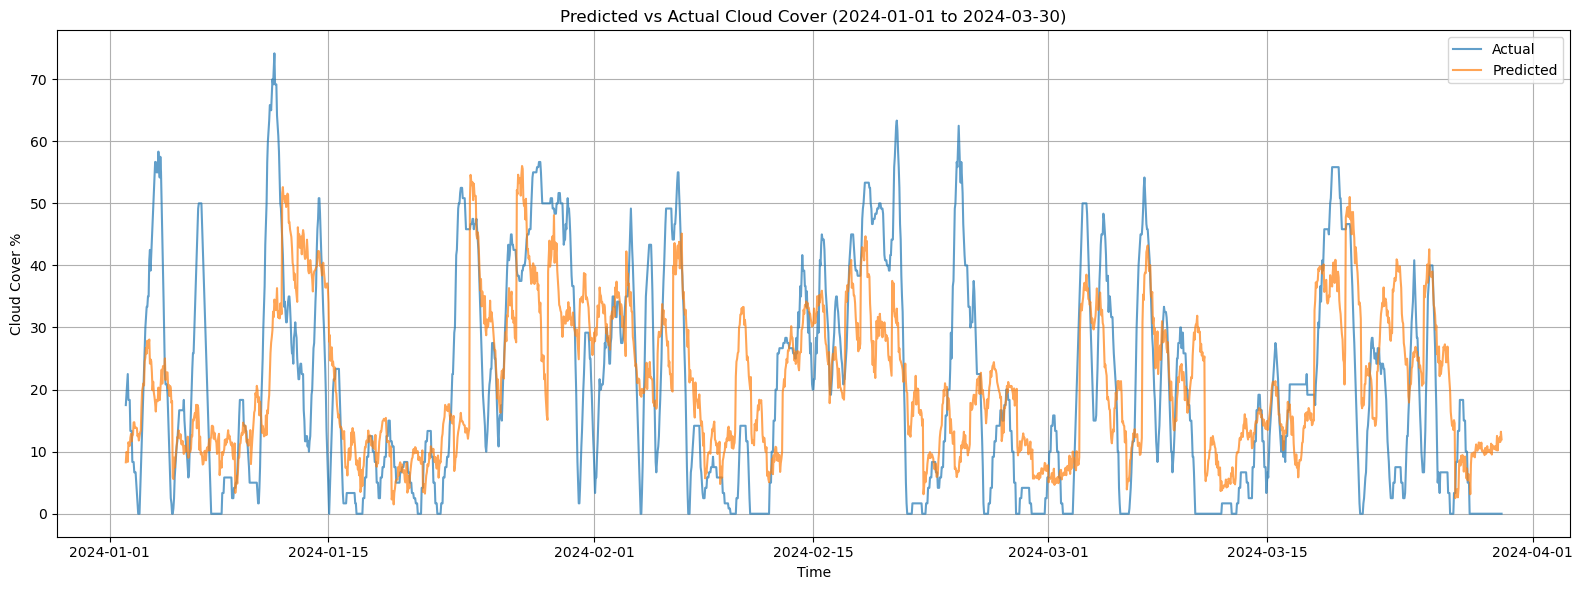

In [63]:
# Plot
plt.figure(figsize=(16,6))
plt.plot(results_df["time"], results_df["actual"], label="Actual", alpha=0.7)
plt.plot(results_df["time"], results_df["predicted"], label="Predicted", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Cloud Cover %")
plt.title("Predicted vs Actual Cloud Cover (2024-01-01 to 2024-03-30)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:03<00:00, 43.39it/s]


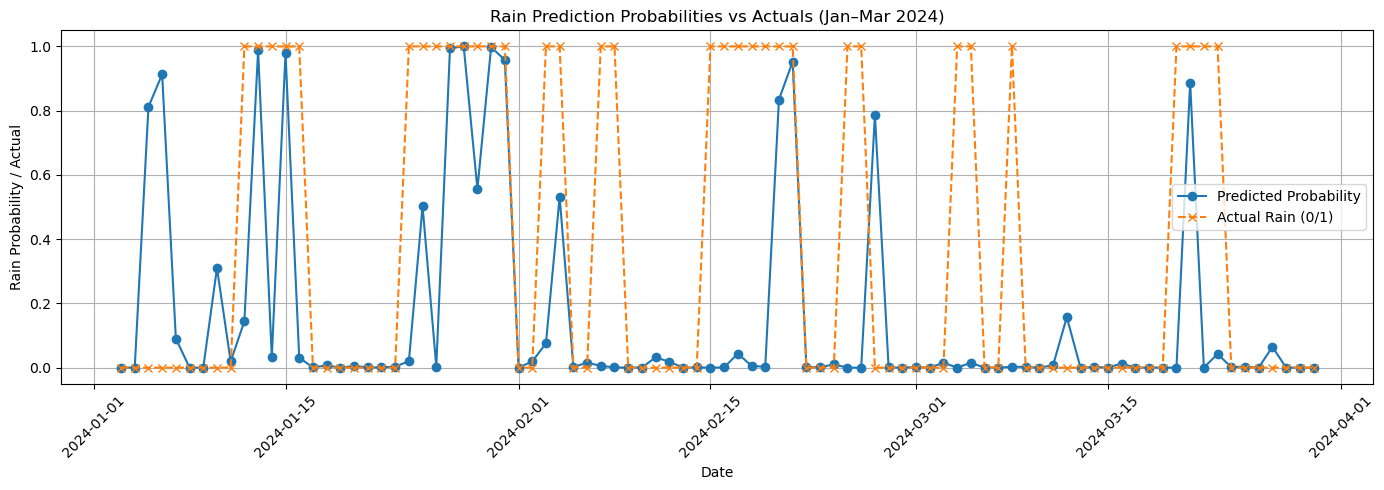

In [64]:
cloud_cover_map = results_df.set_index("time")["predicted"].to_dict()
test["Cloud Cover %"] = test["time"].map(cloud_cover_map).fillna(test["Cloud Cover %"])

# Step 2: Predict rain probability using the updated Cloud Cover %
test = test.sort_values("time").reset_index(drop=True)
start_date = pd.to_datetime("2024-01-01")
end_date = pd.to_datetime("2024-03-30")
step = 24  # Predict every 24 hours
location = (31.95, 35.93)  # Example: Amman

timestamps = []
predicted_probs = []
actual_rain_labels = []

for i in tqdm(range(0, len(test) - 48 - 24 + 1, step)):
    df_48h = test.iloc[i:i+48].copy()
    pred_start_time = df_48h['time'].iloc[-1] + pd.Timedelta(hours=1)
    pred_end_time = pred_start_time + pd.Timedelta(hours=23)

    if pred_end_time < start_date or pred_start_time > end_date:
        continue

    # Predict rain probability
    rain_prob = predict_rain_probability(location, df_48h)["precipitation_probability"]
    
    # Get actual label: Did it rain in the next 24h (Liquid Precipitation > 0.1)?
    next_24h_window = test[
        (test['time'] >= pred_start_time) & (test['time'] <= pred_end_time)
    ]
    if len(next_24h_window) < 24:
        continue
    
    rain_label = int((next_24h_window["Liquid Precipitation"] > 0.1).any())

    # Save results
    timestamps.append(pred_end_time)
    predicted_probs.append(rain_prob)
    actual_rain_labels.append(rain_label)

# Step 3: Plotting (your preferred style)
df_plot = pd.DataFrame({
    'Timestamp': timestamps,
    'Predicted Probability': predicted_probs,
    'Actual': actual_rain_labels
}).sort_values('Timestamp')

plt.figure(figsize=(14, 5))
plt.plot(df_plot['Timestamp'], df_plot['Predicted Probability'], label='Predicted Probability', marker='o')
plt.plot(df_plot['Timestamp'], df_plot['Actual'], label='Actual Rain (0/1)', linestyle='--', marker='x')
plt.title('Rain Prediction Probabilities vs Actuals (Jan–Mar 2024)')
plt.xlabel('Date')
plt.ylabel('Rain Probability / Actual')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
test[(test['time'] > start_date) & (test['time'] > start_date)]['Liquid Precipitation'].head()

24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
Name: Liquid Precipitation, dtype: float64

# Integrating models

In [87]:
def generate_5day_forecast(df_120h, location):
    all_cloud_preds = []

    # ---- 1. Predict Cloud Cover (5 x 24h = 120h total) ----
    for step in [0, 24, 48, 72, 96]:
        df_window = df_120h.iloc[step:step + 48].copy()
        cloud_preds = predict_cloud_cover(location, df_window)  # returns 24 values
        all_cloud_preds.extend(cloud_preds)

    # Check length
    assert len(all_cloud_preds) == 120, f"Expected 120 cloud preds, got {len(all_cloud_preds)}"

    # ---- 2. Insert predicted cloud cover ----
    df_with_cloud = df_120h.copy()
    df_with_cloud['Cloud Cover %'] = 0.0  # ensure float type
    cloud_col_index = df_with_cloud.columns.get_loc('Cloud Cover %')

    # Assign predicted cloud cover to the last 120 hours
    df_with_cloud.iloc[-120:, cloud_col_index] = all_cloud_preds

    # ---- 3. Predict Rain Probabilities using 12h sliding window ----
    rain_probs = []  # Will store 10 values (each 12h forecast)

    for step in range(0, 109, 12):  # steps: 0, 12, ..., 72
        df_window = df_with_cloud.iloc[step:step + 48].copy()
        prob = predict_rain_probability(location, df_window)["precipitation_probability"]
        rain_probs.append(prob)

    # ---- 4. Group into (day, night) tuples ----
    day_night_tuples = [
        (rain_probs[i], rain_probs[i + 1]) for i in range(0, len(rain_probs), 2)
    ]

    return {
        "cloud_cover": all_cloud_preds,           # 120 values (5x24h)
        "rain_probabilities": day_night_tuples    # 5 tuples (day, night)
    }

In [68]:
# API for testing 

def get_ordered_hourly_variables(params):
    return params.get("hourly", [])

cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def get_reading(url, latitude, longtitute, hourly, past_days, future_days):
    params = {
        "latitude": latitude,
        "longitude": longtitute,
        "hourly": hourly,
        "past_days": past_days,
        "forecast_days": future_days
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    #Convert to UTC+3
    start_time = pd.to_datetime(hourly.Time(), unit="s", utc=True) + pd.Timedelta(hours=3)
    end_time = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True) + pd.Timedelta(hours=3)

    hourly_data = {
        "time": pd.date_range(
            start=start_time,
            end=end_time,
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
    }

    for i, var_name in enumerate(get_ordered_hourly_variables(params)):
        hourly_data[var_name] = hourly.Variables(i).ValuesAsNumpy()

    hourly_df = pd.DataFrame(data=hourly_data)

    hourly_df.rename(columns={
        "dew_point_2m": "Air Dew Point",
        "temperature_2m": "Air Temperature (OC)",
        "relative_humidity_2m": "Humidity %",
        "pressure_msl": "Atmospheric Pressure",
        "wind_speed_10m": "Wind Speed (MPS)",
        "wind_direction_10m": "Wind Direction (Degrees)"
    }, inplace=True)
    hourly_df['time'] = hourly_df['time'].dt.tz_localize(None)


    u, v = wind_components(
        hourly_df['Wind Speed (MPS)'].values * units('m/s'),
        hourly_df['Wind Direction (Degrees)'].values * units.degree
    )

    hourly_df['Wind_U'] = u.magnitude.round(2)
    hourly_df['Wind_V'] = v.magnitude.round(2)

    hourly_df.drop(columns=["Wind Speed (MPS)", "Wind Direction (Degrees)"], inplace=True)

    return hourly_df

In [71]:
test_data_full = get_reading(
    "https://api.open-meteo.com/v1/forecast",
    31.95, 35.91,
    ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
     "pressure_msl", "wind_speed_10m", "wind_direction_10m"],
    past_days=3, future_days=3
)

# Step 2: Ensure 'time' column is in proper datetime format with UTC timezone
test_data_full['time'] = pd.to_datetime(test_data_full['time'], utc=True)

# Step 3: Set the start time for slicing (May 9th, 00:00 UTC)
start_time = pd.Timestamp("2025-05-10 00:00:00", tz="UTC")
end_time = start_time + pd.Timedelta(hours=120)

# Step 4: Filter the dataframe based on the start and end time
test_data = test_data_full[(test_data_full['time'] >= start_time) & (test_data_full['time'] < end_time)].reset_index(drop=True)

In [72]:
len(test_data)

120

In [73]:
test_data.head()

,time,Air Temperature (OC),Air Dew Point,Humidity %,Atmospheric Pressure,Wind_U,Wind_V
0,2025-05-10 00:00:00+00:00,22.559999,2.086033,26.0,1014.700012,1.80,-1.44
1,2025-05-10 01:00:00+00:00,22.010000,1.617485,26.0,1014.599976,3.60,-1.08
2,2025-05-10 02:00:00+00:00,21.110001,0.850447,26.0,1014.099976,3.60,-0.72
3,2025-05-10 03:00:00+00:00,21.260000,-0.129288,24.0,1014.400024,2.88,-1.80
4,2025-05-10 04:00:00+00:00,21.059999,-0.298238,24.0,1014.200012,2.52,-0.72


In [49]:
test_data.head()

,time,Air Temperature (OC),Air Dew Point,Humidity %,Atmospheric Pressure,Wind_U,Wind_V
0,2025-05-09 03:00:00,20.809999,0.594678,26.0,1013.700012,3.24,-1.08
1,2025-05-09 04:00:00,20.410000,0.253585,26.0,1013.599976,0.72,0.72
2,2025-05-09 05:00:00,20.510000,-0.202272,25.0,1013.599976,-0.72,0.36
3,2025-05-09 06:00:00,20.410000,-0.287174,25.0,1013.900024,-2.16,-0.72
4,2025-05-09 07:00:00,21.160000,0.349470,25.0,1014.599976,-0.36,-0.72


In [88]:
forecast = generate_5day_forecast(test_data, (31.95, 35.91))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


In [89]:
forecast

{'cloud_cover': [1.5057158,
  3.7337759,
  1.4468029,
  3.3403795,
  0.75148344,
  2.1134083,
  2.1345842,
  1.9178848,
  3.0852633,
  3.1135738,
  3.9292765,
  3.117981,
  2.8078144,
  2.1592453,
  2.7828512,
  2.5974886,
  2.3120663,
  3.145081,
  3.879602,
  2.7631934,
  2.7852705,
  2.286679,
  1.7479441,
  1.1481028,
  54.861336,
  48.54815,
  48.80996,
  48.151443,
  49.613228,
  51.226944,
  47.248924,
  51.261646,
  50.234287,
  55.59915,
  55.556026,
  49.952717,
  55.323273,
  56.339775,
  61.813065,
  51.478622,
  51.934006,
  50.001293,
  46.369114,
  49.923973,
  48.884285,
  49.681465,
  44.580997,
  48.13807,
  48.447372,
  45.43518,
  44.653145,
  44.593346,
  47.069237,
  47.572712,
  41.338696,
  48.45116,
  47.13557,
  48.783066,
  52.20683,
  44.140312,
  50.135937,
  51.647873,
  55.258934,
  42.991444,
  47.026096,
  43.987106,
  39.339214,
  43.679184,
  43.54469,
  43.674786,
  43.49617,
  41.10605,
  31.859587,
  37.43982,
  36.043335,
  34.942,
  33.766846,
  